In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import dump
import numpy as np
from tqdm import tqdm

In [3]:
import Py_FTP_Langevin as ftp

In [4]:
k_B = 1.38066e-23    #! Boltzmann constant in (J/K)

# First time passage simulations

In [5]:
#//! *********** PARAMETERS PARTICLE PROPERTIES *********** !
MM = 28.9647  #;  //! Molecular weight of fluid molecules (kg/kmol)
Rho_p = 1800. #; //! PPs mass density
Dp = 20e-09

#//! *********** SIMULATION PARAMETERS *********** !
N_runs = 500 #;
Box_L_factor_dmax = 50. #4 #; //! Box size as factor of D_p
T_g = 1700. #;            //! Fluid temperature
P_g = 101300. #;          //! Fluid pressure
phi_p = 0.01 / 100 #;   //! Particles number concentration (1000 ppm = 0.01)    
with_collisions = True
with_rel_motion = True
with_rotation = False

#//! *********** LANGEVIN PARAMETERS *********** !
run_taus_min = 120 #; // Keep in 100 to be accurate with LD theory (otherwise the 6*D*t is not strictly respected)
LD_dt_factor = 1e-03 #;

#//! *********** PARAMETERS INT. POTENTIALS *********** !
A = 0 #2.62e-19    #;    //! Hamaker constant (J) 2.38e-19
s_LJ = 0 #0.35e-09 #5.95e-10 #; //! LJ repulsive form parameter
alpha_dp = 0.01
factor_vdw = 1 #.05
direct = "/home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/Simulations/aggregate_info";

In [6]:
model = ftp.Pymodel(direct)
model

In [7]:
#model.Set_prop_default()
model.Set_prop(MM,Rho_p,N_runs,Box_L_factor_dmax,
               T_g,P_g,phi_p,run_taus_min,
               LD_dt_factor,A,s_LJ,alpha_dp,factor_vdw,Dp,
               with_collisions,with_rel_motion,with_rotation,direct)

In [8]:
model.Show_prop()

SIMULATION
run_taus_min:                 120
L_box/R_max                   50
phi_p (ppm)                   100
Path                          /home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/Simulations/aggregate_info
alpha_dp                      0.01
factor_vdw                    1
with_collisions               1
with_rel_motion               1
with_rotation                 0
 
FLUID PROPERTIES
Temperature (K)               1700
Pressure (Pa)                 101300
Viscosity (kg/m*s)            5.66636e-05
Fluid mfp (nm)                489.736
Maxwell avg vel (m/s)         1114.75
 
PARTICLES PROPERTIES          
Particles mean diameter (nm)  20
Hamaker constant A/(k_b*T)    0
Repuls. form param. s_LJ (m)  0
Bulk mass density (kg/m^3)    1800
 


In [9]:
ftp.Init_Random()
ftp.Make_output_folder()

In [10]:
files = ftp.get_dir_files(direct)
N_files = len(files)

In [11]:
def Export_current_sim(ftp_model,i,normalize=False):
    x1,y1,z1,r1 = ftp_model.Get_spheres(1)
    x2,y2,z2,r2 = ftp_model.Get_spheres(2)
    ofname = "ovito_out/Simulation_01.dump"
    radius = np.concatenate((r1, r2))
    if (normalize):
        nor_factor = np.mean(radius)
        radius = radius/nor_factor
    box_l = ftp_model.L_box/nor_factor
    box = ((-0.5*box_l,0.5*box_l),\
           (-0.5*box_l,0.5*box_l),\
           (-0.5*box_l,0.5*box_l))
    pos = np.array([np.concatenate((x1/nor_factor, x2/nor_factor)),
                   np.concatenate((y1/nor_factor, y2/nor_factor)),
                   np.concatenate((z1/nor_factor, z2/nor_factor))]).transpose()
    vel = pos *0
    
    N = len(x1)+len(x2)
    dump.writeOutput(ofname, N, i, box, radius=radius, pos=pos, v=vel)
    return

def run(ftp_model, model, n_steps):
    for j in range(n_steps):
        ftp_model.OneRW_step_LD(model)
    return

def isNaN(num):
    if float('-inf') < float(num) < float('inf'):
        return False 
    else:
        return True

In [12]:
ftp_model = ftp.PyFTP(model)

path_agg = direct + "/" + files[0].decode('utf-8')
print(path_agg)

ftp_model.Load_aggregates_external(path_agg, model)

ftp_times = np.asarray([])
#t_reses = np.asarray([])
#d_ij_mins = np.asarray([])

/home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/Simulations/aggregate_info/Agglomerate_N_000000001_Agg_00000001.dat


In [13]:
for k in tqdm(range(N_runs)): #N_files):
    ftp_model.Restart_ftp(model)
    #ftp_model.show_spheres()
    #if (k == 0):
    #    ftp.Show_parameters(spheres2, model)
    ftp_model.Move_2_origin()
    ftp_model.Random_init_location()
    #Export_current_sim(ftp_model,0,True)
    i=1
    it_exp = 1
    collision = False
    while(not collision):
        collision = ftp_model.run(model, 1)
        if(isNaN(ftp_model.t_res)):
            print("d_time ",ftp_model.d_time, " t_res ",ftp_model.t_res)
            break
        #if(i%10==0):
            #Export_current_sim(ftp_model,it_exp,True)
            #it_exp +=1
        i += 1
    ftp_times = np.append(ftp_times, ftp_model.t_res)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [35:02<00:00,  4.20s/it]


/home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jose/Desktop/Gitlab/mitacs/mitacs_project/First_time_passage/FTP_Langevin_simulations/venv/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


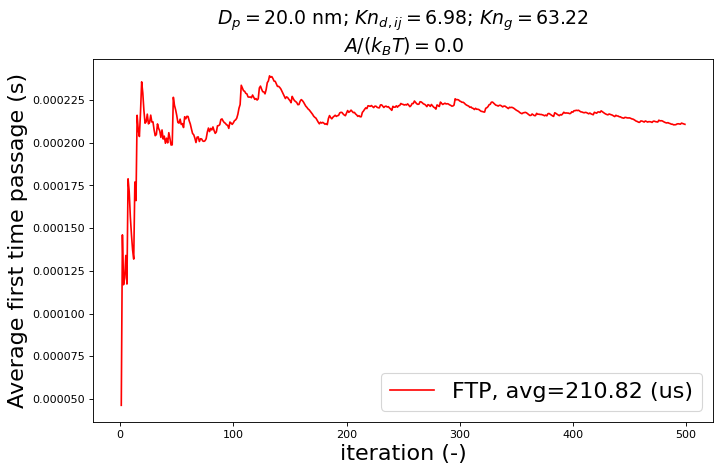

(<matplotlib.legend.Legend at 0x7ff86caf5160>, None)

In [14]:
import matplotlib.pyplot as plt

avg_ftp_times = np.zeros_like(ftp_times)
for i in range(len(ftp_times)):
    avg_ftp_times[i] = np.mean(ftp_times[:i])

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(avg_ftp_times,"-r",label="FTP, avg="+str(round(avg_ftp_times[-1]*1e+06, 2))+" (us)")
ax1.set_xlabel('iteration (-)', fontsize=20)
ax1.set_ylabel('Average first time passage (s)', fontsize=20)
Kn_d_ij = ftp_model.Kn_d_ij
kn_g_avg = ftp_model.Kn_g_avg
title = "$D_p=$"+str(round(Dp*1e+09,2))+" nm; $Kn_{d,ij}=$"+\
        str(round(Kn_d_ij,2))+"; $Kn_g=$"+str(round(kn_g_avg,2))+"\n"+\
        "$A/(k_BT)=$"+str(round(A/(k_B*T_g),2))
plt.title(title,fontsize=17)
plt.legend(fontsize=20, loc=0), plt.show()

In [15]:
# Box size
L = ftp_model.L_box
Rc = ftp_model.Rc
V_box = pow(L,3)

tau_ij = ftp_model.Tau_ij

t_ij = avg_ftp_times[-1]/tau_ij

H = V_box/(pow(Rc,3)*t_ij)

In [16]:
L/Rc

50.0

In [17]:
def H_function(Kn_d2):
    cc1 = 25.836
    cc2 = 11.211
    cc3 = 3.502
    cc4 = 7.211
    H_gop = (4.0*np.pi*pow(Kn_d2,2)+cc1*pow(Kn_d2,3)+
        np.sqrt(8.0*np.pi)*cc2*pow(Kn_d2,4))/(1.0+cc3*Kn_d2+
        cc4*pow(Kn_d2,2)+cc2*pow(Kn_d2,3))
    return H_gop

def H_diffusive(Kn_d2):
    H_d = 4*np.pi*pow(Kn_d2,2)
    return H_d

def H_ballistic(Kn_d2):
    H_b = np.sqrt(8*np.pi)*Kn_d2
    return H_b

In [18]:
Kn_d2 = np.logspace(np.log10(1e-02),np.log10(1e+02), 500)
H_theo = H_function(Kn_d2)

H_theo_d = H_diffusive(Kn_d2)
H_theo_b = H_ballistic(Kn_d2)

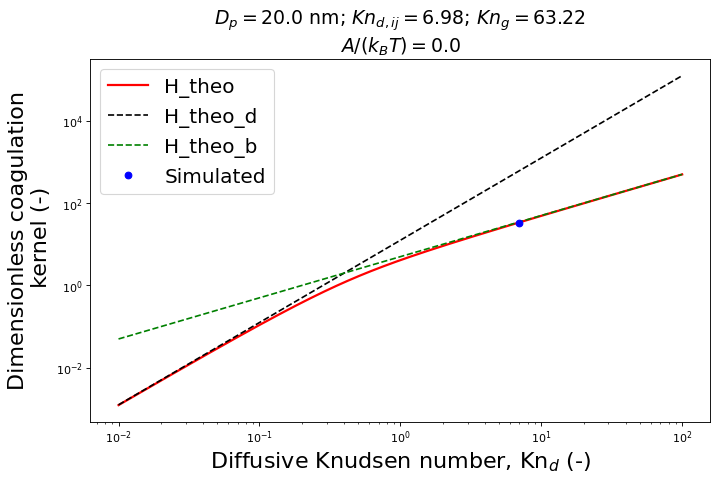

(<matplotlib.legend.Legend at 0x7ff86c620f40>, None)

In [19]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.loglog(Kn_d2,H_theo,"-r", linewidth=2,label="H_theo")
ax1.loglog(Kn_d2,H_theo_d,"--k",label="H_theo_d")
ax1.loglog(Kn_d2,H_theo_b,"--g",label="H_theo_b")
ax1.loglog(Kn_d_ij,H,"o b",label="Simulated")
ax1.set_xlabel('Diffusive Knudsen number, Kn$_d$ (-)', fontsize=20)
ax1.set_ylabel('Dimensionless coagulation\n kernel (-)', fontsize=20)
Kn_d_ij = ftp_model.Kn_d_ij
kn_g_avg = ftp_model.Kn_g_avg
title = "$D_p=$"+str(round(Dp*1e+09,2))+" nm; $Kn_{d,ij}=$"+\
        str(round(Kn_d_ij,2))+"; $Kn_g=$"+str(round(kn_g_avg,2))+"\n"+\
        "$A/(k_BT)=$"+str(round(A/(k_B*T_g),2))
plt.title(title,fontsize=17)
plt.legend(fontsize=18, loc=0), plt.show()